In [152]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from IPython.display import clear_output
from alignment_tools import align_stacks

def compare_itk(fixed_image, moving_image):
    fixed_image = np.array(sitk.GetArrayViewFromImage(fixed_image))
    moving_image = np.array(sitk.GetArrayViewFromImage(moving_image))
    fixed_image = fixed_image/np.max(fixed_image)
    moving_image = moving_image/np.max(moving_image)
    interact(display_images_with_color, image_z=(0,fixed_image.shape[0]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_image));

def display_images_with_color(image_z, alpha, fixed, moving):
    plt.figure(figsize=(10,10))
    img = np.array([fixed[image_z],moving[image_z],np.zeros(fixed.shape[1:])])
    img = np.swapaxes(img, 0,2)
    plt.imshow(img);
    plt.axis('off')
    plt.show()

# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

root_path = '/data/salglcinssalglcglc'
tifs = os.listdir(root_path)

In [160]:
image_path = os.path.join(root_path,tifs[1])
im2 = io.imread(image_path)
moving_image = sitk.GetImageFromArray(im2[:,0,:,:])
# moving_image.SetOrigin((0, 0, 0))
image_path = os.path.join(root_path,tifs[0])
im1 = io.imread(image_path)
fixed_image = sitk.GetImageFromArray(im1[:,0,:,:])
# fixed_image.SetOrigin((0, 0, 0))

In [169]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

compare_itk(fixed_image, moving_resampled)

interactive(children=(IntSlider(value=6, description='image_z', max=12), FloatSlider(value=0.5, description='a…

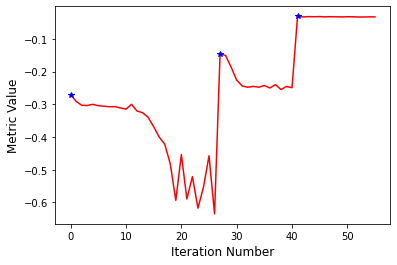

In [170]:


registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-8, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))

In [171]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

compare_itk(fixed_image, moving_resampled)

interactive(children=(IntSlider(value=6, description='image_z', max=12), FloatSlider(value=0.5, description='a…